Ildar Rakhmatulin ildarr2016@gmail.com

# Import libraries
To install libraries in Python, you can use a package manager like pip, which comes pre-installed with most Python distributions.



In [98]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.fftpack
from scipy.fft import fftshift
from scipy import signal


# Import Dataset

Load dataset
https://github.com/Ildaron/ironbci  
The following dataset structure is used  

ch1	ch2	ch3	ch4	ch5	ch6	ch7	ch8  
..    ..    ..  ..  ..  ..  ..  ..    
..    ..    ..  ..  ..  ..  ..  ..  
where with according international 10-20 system EEG Placement  
Ch1 - Fz  
Ch2 - Cz  
Ch3 - Pz  
Ch4 - T3  
Ch5 - C3  
Ch6 - Fp1     
Ch7 - C4  
Ch8 - T4  
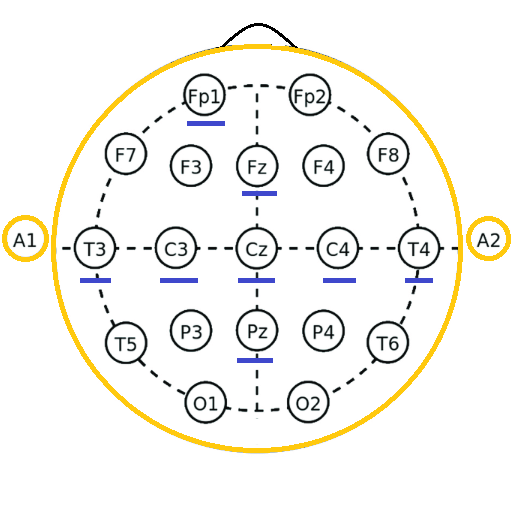



          ch1     ch2      ch3      ch4      ch5     ch6      ch7      ch8
0     23899.1  2951.1  36442.2  38418.6  12414.9  3759.5  31001.4  52775.3
1     23917.7  3048.0  36463.8  38344.3  12448.1  3726.3  31032.4  52223.4
2     23984.9  3148.2  36525.1  39002.6  12520.4  3601.3  31103.2  53175.1
3     24016.8  3183.3  36551.5  39602.8  12548.5  3473.0  31133.2  54514.6
4     23960.3  3061.0  36494.8  39256.9  12475.6  3549.7  31061.9  54321.3
...       ...     ...      ...      ...      ...     ...      ...      ...
7115  23896.6  3893.1  37567.5  38276.6  11183.1  4515.5  31611.9  48532.8
7116  23850.2  3780.5  37514.3  38075.4  11119.7  4572.2  31551.9  48566.2
7117  23766.2  3644.2  37432.3  37477.1  11029.8  4755.0  31464.2  47165.5
7118  23768.4  3709.8  37443.6  37362.9  11048.4  4738.0  31481.5  46410.0
7119  23841.3  3830.5  37514.9  37800.0  11130.5  4623.2  31560.6  47139.6

[7120 rows x 8 columns]


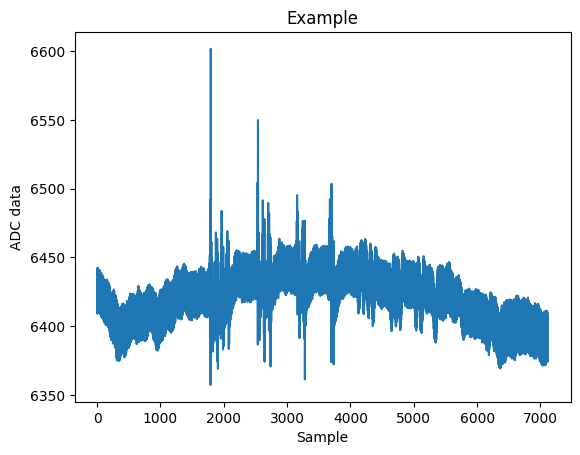

In [99]:
#len_data = 1169
#value_data = 27

dataset_y_row = pd.read_excel("/content/drive/MyDrive/EEG_course/dataset/dataset.xlsx")
print(dataset_y_row)
dataset_y = dataset_y_row.transpose()

channel = 0
dataset_one_ch = dataset_y.iloc[channel]
dataset_one_ch = round(1000000*4.5*(dataset_one_ch/16777215),2)

plt.plot(dataset_one_ch)
plt.title("Example")
plt.ylabel('ADC data')
plt.xlabel('Sample')
plt.show()

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Signal proccessing
Signal processing for EEG (Electroencephalography) data involves a range of techniques used to analyze and extract meaningful information from the electrical signals recorded from the brain. EEG signals are complex and often contaminated with noise, artifacts, and other unwanted components. Signal processing methods are essential for enhancing the signal quality, identifying patterns, and understanding brain activity.

## Band Pass Filter



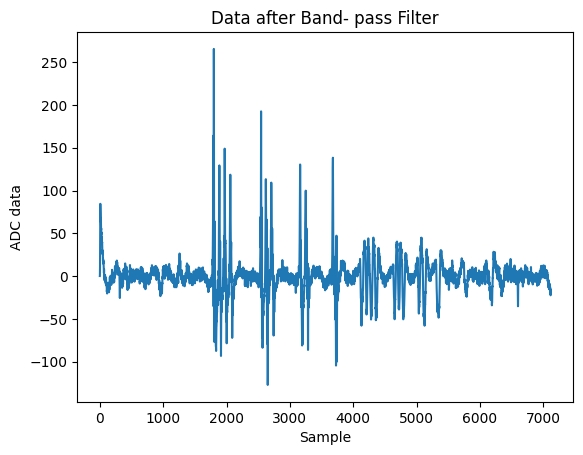

In [101]:


data_after_band_pass_filter = dataset_y

def butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

fps = 250
cutoff_high=1
cutoff_low=25
x=[]
for a in range(0,8,1):
    filtered_sine_high = butter_highpass_filter(dataset_y.iloc[a], cutoff_high, fps)
    filtered_high_pass= butter_lowpass_filter(filtered_sine_high, cutoff_low, fps)
    data_after_band_pass_filter.iloc[a] = filtered_high_pass


plt.plot(data_after_band_pass_filter.iloc[0])
plt.title("Data after Band- pass Filter")
plt.ylabel('ADC data')
plt.xlabel('Sample')
plt.show()

##Visualisation

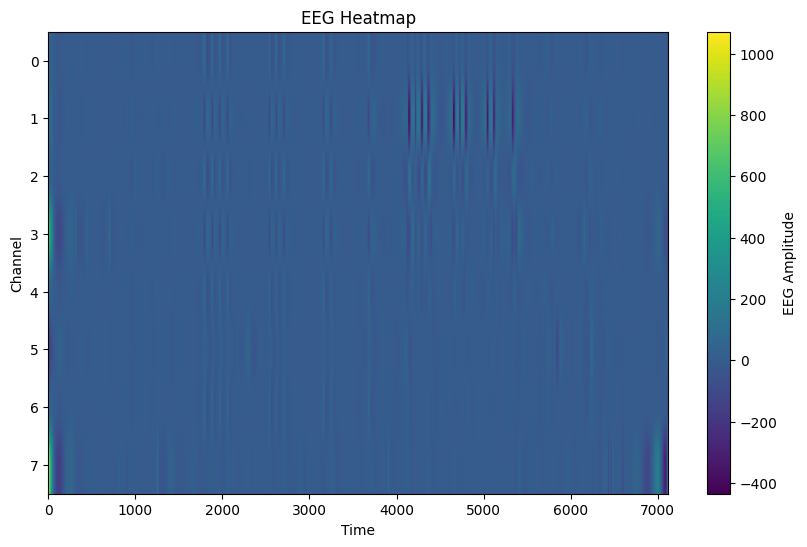

In [102]:
ch_names = ["1", "2", "3", "4", "5", "6", "7", "8"]
eeg_data = data_after_band_pass_filter
# Create the heatmap
plt.figure(figsize=(10, 6))
heatmap = plt.imshow(eeg_data, cmap='viridis', aspect='auto')
plt.colorbar(heatmap, label='EEG Amplitude')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.title('EEG Heatmap')
plt.show()







##3D graph

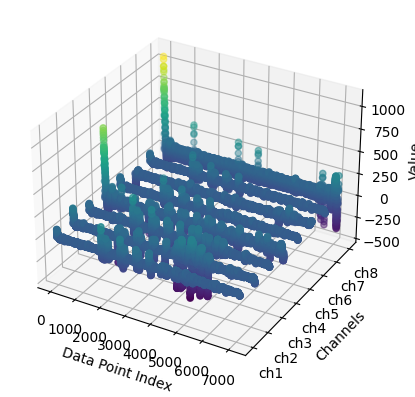

In [103]:
from mpl_toolkits.mplot3d import Axes3D

data = data_after_band_pass_filter
df = pd.DataFrame(data)
channel_names = ["ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8"]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(np.arange(df.shape[1]), np.arange(len(channel_names)))

z = df.values.flatten()
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

ax.set_xlabel('Data Point Index')
ax.set_ylabel('Channels')
ax.set_zlabel('Value')

ax.set_yticks(np.arange(len(channel_names)))
ax.set_yticklabels(channel_names)

plt.show()


##Heat map

(8, 7120)
(7120, 8)


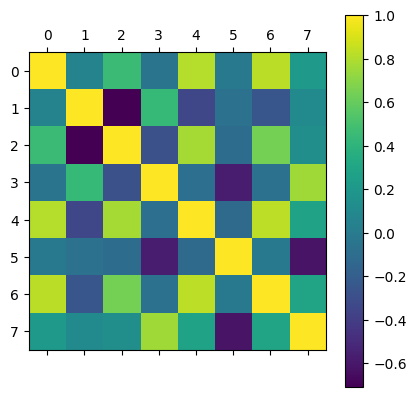

In [104]:
print(data_after_band_pass_filter.shape)
data_after_band_pass_filter_transpor = np.transpose(data_after_band_pass_filter)
print(data_after_band_pass_filter_transpor.shape)
dataframe = pd.DataFrame(data_after_band_pass_filter_transpor)
plt.matshow(dataframe.corr())
plt.colorbar()
plt.show()







https://mne.tools/stable/auto_examples/io/read_noise_covariance_matrix.html#sphx-glr-auto-examples-io-read-noise-covariance-matrix-py

## MNE Topomap

In [105]:
 !pip install mne
 # https://mne.tools/stable/generated/mne.EvokedArray.html
import mne

In [106]:
mne.channels.get_builtin_montages()

['standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'biosemi16',
 'biosemi32',
 'biosemi64',
 'biosemi128',
 'biosemi160',
 'biosemi256',
 'easycap-M1',
 'easycap-M10',
 'easycap-M43',
 'EGI_256',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'mgh60',
 'mgh70',
 'artinis-octamon',
 'artinis-brite23',
 'brainproducts-RNP-BA-128']

In [107]:
data_after_band_pass_filter = np.array(data_after_band_pass_filter)
data_after_band_pass_filter = data_after_band_pass_filter.reshape((8, 7120))
data_after_band_pass_filter = pd.DataFrame(data_after_band_pass_filter)

standard_montage = mne.channels.make_standard_montage('standard_alphabetic')
n_channels = 8
fake_info = mne.create_info(
    ch_names=["Fp1", "Fz", "Cz", "Pz", "T3", "C3", "C4", "T4"],
    sfreq=250.,
    ch_types='eeg')
print (fake_info)

fake_evoked = mne.EvokedArray(data_after_band_pass_filter, fake_info)
fake_evoked.set_montage(standard_montage, on_missing='ignore')

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, Cz, Pz, T3, C3, C4, T4
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>


<Evoked | '' (average, N=1), 0 – 28.476 s, baseline off, 8 ch, ~463 kB>

[ 0.  7. 14. 21.]


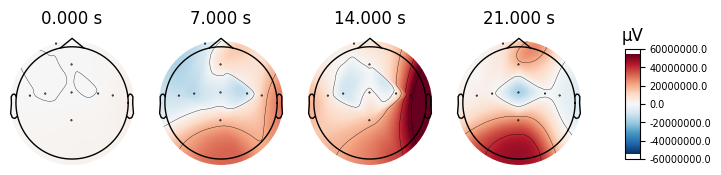

In [108]:
times_to_plot = np.arange(0, 28., 7)
print (times_to_plot)
fake_evoked.plot_topomap(times_to_plot, ch_type="eeg", ncols=len(times_to_plot), nrows="auto");

In [131]:
#!pip install pyvista
#!pip install pyvistaqt
#https://mne.tools/dev/auto_examples/visualization/brain.html#sphx-glr-auto-examples-visualization-brain-py
from mne.datasets import sample

data_path = "/content/drive/MyDrive/EEG_course/dataset/"

subjects_dir =  "/content/drive/MyDrive/EEG_course/dataset/"



brain_kwargs = dict(alpha=0.1, background="white", cortex="low_contrast")
brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)

stc = mne.read_source_estimate(sample_dir / "sample_audvis-meg")
stc.crop(0.09, 0.1)

kwargs = dict(
    fmin=stc.data.min(),
    fmax=stc.data.max(),
    alpha=0.25,
    smoothing_steps="nearest",
    time=stc.times,
)
brain.add_data(stc.lh_data, hemi="lh", vertices=stc.lh_vertno, **kwargs)
brain.add_data(stc.rh_data, hemi="rh", vertices=stc.rh_vertno, **kwargs)

RuntimeError: ignored